<a href="https://colab.research.google.com/github/MatiasMingo/ML-Colab-Projects/blob/main/Personal%20Projects/DQL_ResourceManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

**Environment and Agent**

---



We are individual organisms (we manage ourselves towards the world)

We are one organism (we manage each other)

------> Agent is also an environment 

**IDEA: Society is not one environment, there should be multiple environments or layers to society, from smallest to biggest. The smallest environment should be the individual, then a community and then a cluster of communities.


**IDEA: First focus on supply and demand between companies or industries

*   Environment: group of companies. Industry based economy
*   Agent: company. 
*   Actions: supply, demand


Environment:

*   companies
*   supply-chain relationships
*   random ocurrences
*   random ocurrences


Agent:

*   demand of products and/or services at a point in time
*   supply of products and/or services at a point in time
*   capital (categorized by liquidity or nature) at a point in time
*   relation with other agents
*   supply of products and/or services at a point in time

Actions
*   demand of products and/or services at a point in time
*   supply of products and/or services at a point in time
*   CONSIDER delays in and time for executing 







In [ ]:
class Environment(Env):

  def __init__(self):
    # Actions we can take, buy, sell, do, stay
    self.action_space = Discrete(4)
    # UNKNOWN - DEFINE ******
    self.observation_space = Box(low=np.array([0]), high=np.array([100]))
    # Random initial state - Amount of Money (1000 +- 500 USD)
    self.state = 1000 + random.randint(-500,500)
    # Length of interaction - DEFINE *****
    self.interaction_length = 60

  def step(self, action):
    # Apply action - DEFINE (How much money was made) ******
    previous_state = self.state
    self.state += action 
    # Reduce shower length by 1 second
    self.interaction_length -= 1 
    
    # Calculate reward
    if self.state >= previous_state: 
        reward =1 
    else: 
        reward = -1 
    
    # Check if interaction is done
    if self.interaction_length <= 0: 
        done = True
    else:
        done = False
    
    # Apply temperature noise
    #self.state += random.randint(-1,1)
    # Set placeholder for info
    info = {}
    
    # Return step information
    return self.state, reward, done, info
  
  def render(self):
      # Implement viz
      pass
  
  def reset(self):
      # Reset state
      self.state = 1000 + random.randint(-500,500)
      # Reset interaction time
      self.interaction_length = 60 
      return self.state

In [ ]:
env = Environment()

In [ ]:
env.observation_space.sample()

In [ ]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

# Create a Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model 

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

# Build Agent with Keras-RL

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=True)

# Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

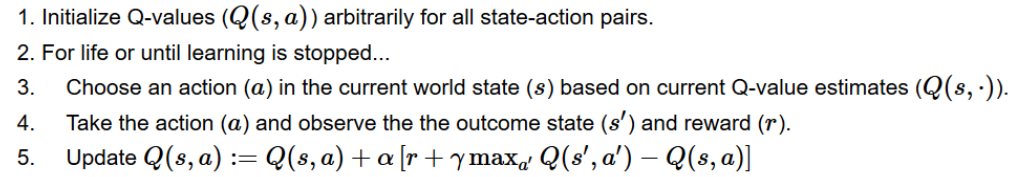